### **Mental-Health Text Classification with Transformers (16 Classes) - Quick Introduction**

Online communities and support forums host millions of mental-health–related posts every month. Tagging these posts by **topic** (e.g., *anxiety*, *PTSD*, *depression*) enables better moderation tools, trend monitoring, and routing to appropriate helpers. Most platforms cannot rely on keywords alone—language is nuanced, posts are long, and categories overlap.

In this project, we aim to build an end-to-end text classifier using Hugging Face Transformers to categorize mental-health-related posts into one of 16 predefined themes:

**adhd, healthanxiety, bipolarreddit, socialanxiety, bpd, normal, autism, ptsd, suicidewatch, depression, alcoholism, anxiety, lonely, EDAnonymous, schizophrenia, addiction.**

This is a single-label multi-class classification task, where we will leverage pretrained Transformer encoder models with a classification head. The loss function used for training will be cross-entropy.

To achieve this, we will be training and comparing the performance of three different Transformer models:
- **RoBERTa-base**
- **DeBERTa-v3-base**
- **ModernBERT-large**

By evaluating these models, we can determine which one is best suited for this specific text classification task.

This notebook is organized into the following sections:

1.  **Collab Setup**: Prepare your setup in collab.
2.  **Packages Loading**: Load all necessary packages.
3.  **Utility Functions**: Defining reusable functions used throughout the notebook.  
4.  **Data Loading**: Loading the dataset and preparing it for model training, including tokenization.
5.  **Models Definition, Configuration, Training, Inference on Unseen Data**: Describing the models used, their configurations, training and performances
6.  **Results, Interpretation & Future Works**

### **1. Collab Setup**

In [ ]:
# Needed to upload these three files :
# - Your .env file containing your WANDB_API_KEY file
# The poetry.lock file
# The pyproject.toml file
from google.colab import files
files.upload()

In [ ]:
# Install Poetry and any needed dependency
!pip install poetry==2.2.1
!poetry install --no-root
!pip install evaluate

### **2. Packages Loading**

In [1]:
import os
import json
import inspect
from dataclasses import dataclass, asdict
from sklearn.model_selection import train_test_split
from typing import Dict, Optional
import numpy as np
import pandas as pd
import torch
# from huggingface_hub import notebook_login : No needed for you since you don;t have access to push on the Hugging Face repo
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    Trainer,
    EarlyStoppingCallback
)
from huggingface_hub import HfApi
from transformers.training_args import TrainingArguments as HFTrainingArguments
import evaluate
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import transformers # Keep this import for printing version
from dotenv import load_dotenv

load_dotenv()

print("transformers", transformers.__version__)
print("TrainingArguments from:", HFTrainingArguments.__module__)
print("evaluate   ", evaluate.__version__)
print("torch      ", torch.__version__, "CUDA:", torch.cuda.is_available()) # Corrected cuda check

transformers 4.57.1
TrainingArguments from: transformers.training_args
evaluate    0.4.6
torch       2.9.0+cpu CUDA: False


### **3. Utility Functions**

This section contains reusable functions that are used throughout the notebook for various tasks such as data processing, model evaluation, and interacting with the Hugging Face Hub.

By defining these functions separately, the main sections of the notebook remain cleaner and more focused on the core steps of the ML workflow.

In [2]:
#  Config
@dataclass
class Config:
    model_name: str = "roberta-large"             # or microsoft/deberta-v3-base
    max_length: int = 384
    batch_size: int = 16
    epochs: int = 5
    lr: float = 2e-5
    weight_decay: float = 0.01
    warmup_ratio: float = 0.1
    scheduler: str = "cosine"
    seed: int = 42
    output_dir: str = "mh_sent_model"
    report_to: str = "none"
    label_smoothing: float = 0.05
    save_total_limit: int = 2
    save_safetensors: bool = True
    eval_strategy: str = "epoch"
    eval_steps: int = 200
    logging_steps: int = 50
    gradient_accumulation: int = 1
    fp16: bool = True
    use_early_stopping: bool = True
    early_stopping_patience: int = 2
    # Hugging Face Hub
    hub_repo_id: Optional[str] = None
    hub_private: bool = True
    push_during_training: bool = False            # keep False; push best at end

##### _Some Quick Helper Functions_

In [3]:
def set_seed(seed: int):
    """Sets the seed for reproducibility across numpy, torch, and potentially Python's hash.

    Ensures that random operations are deterministic for easier debugging and comparison
    of results across different runs.
    """
    os.environ['PYTHONHASHSEED'] = str(seed) # Set Python hash seed
    np.random.seed(seed) # Set numpy seed
    torch.manual_seed(seed) # Set torch seed for CPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed) # Set torch seed for all GPUs
    print(f"Seed set to {seed}") # Inform the user that the seed has been set

##### _Data Processing Functions_

They're functions responsible for preparing the loaded data for model training.

**`create_datasets`**: This function takes the pandas DataFrames (`train_df`, `val_df`, `test_df`) and converts them into Hugging Face `Dataset` objects, organized within a `DatasetDict`. It also creates the necessary mappings between class labels (strings) and integer IDs (`label2id` and `id2label`) which are required for the classification models.

**`tokenize_datasets`**: This function is used for converting the raw text data into a numerical format that Transformer models can process. It uses a tokenizer (compatible with the chosen model) to:
*   Break down the text into tokens.
*   Convert tokens into input IDs.
*   Add attention masks and handle padding/truncation based on the specified `max_length`.

In [4]:
def create_datasets(train_df: pd.DataFrame, val_df: pd.DataFrame, test_df: pd.DataFrame):
    """Creates a DatasetDict from dataframes."""
    classes = sorted(train_df["label"].unique().tolist())
    label2id = {lbl: i for i, lbl in enumerate(classes)}
    id2label = {i: lbl for lbl, i in label2id.items()}
    num_labels = len(classes)

    def to_ids(df):
        df = df[["text", "label"]].copy()
        df["label"] = df["label"].map(label2id)
        return df

    raw = DatasetDict({
        "train": Dataset.from_pandas(to_ids(train_df), preserve_index=False),
        "validation": Dataset.from_pandas(to_ids(val_df), preserve_index=False),
        "test": Dataset.from_pandas(to_ids(test_df), preserve_index=False),
    })

    if "label" in raw["train"].column_names:
        raw = raw.rename_column("label", "labels")

    return raw, label2id, id2label, num_labels

def tokenize_datasets(raw_datasets: DatasetDict, model_name: str, max_length: int):
    """Tokenizes the datasets."""
    tok = AutoTokenizer.from_pretrained(model_name, force_download=True)
    collator = DataCollatorWithPadding(tokenizer=tok)

    def tokenize_function(examples):
        return tok(examples["text"], truncation=True, max_length=max_length)

    tok_ds = raw_datasets.map(tokenize_function, batched=True, remove_columns=["text"])

    print("Tokenized datasets:")
    print(tok_ds)

    return tok_ds, tok, collator

##### _Evaluation Functions_

This section contains functions used to keep trained models' parameters, and evaluate their performance.

**`compute_metrics`**: This function calculates various evaluation metrics (like accuracy, F1-score, precision, and recall) given the model's predictions and the true labels. It's designed to be used with the Hugging Face Trainer during evaluation.

**`evaluate_model`**: This function takes a trained model (via the Trainer), the tokenized datasets, and label mappings to perform a comprehensive evaluation on a specified dataset split (e.g., the test set). It uses the `compute_metrics` function and also generates a classification report and a confusion matrix to visualize the model's performance across different classes.

**`plot_loss_curves`**: This function visualizes the training and validation loss over the training steps. This helps in understanding the training progress and detecting potential issues like overfitting.

In [5]:
def compute_metrics(eval_pred):
    """Computes metrics for evaluation."""
    accuracy_metric = evaluate.load("accuracy")
    f1_metric = evaluate.load("f1")
    precision_metric = evaluate.load("precision")
    recall_metric = evaluate.load("recall")

    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {
        "accuracy": accuracy_metric.compute(predictions=preds, references=labels)["accuracy"],
        "macro_f1": f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"],
        "macro_prec": precision_metric.compute(predictions=preds, references=labels, average="macro")["precision"],
        "macro_rec": recall_metric.compute(predictions=preds, references=labels, average="macro")["recall"],
    }

def evaluate_model(trainer: Trainer, tokenized_datasets: DatasetDict, id2label: Dict[int, str], num_labels: int, split: str = "test"):
    """Evaluates the model on a specified dataset split and prints a classification report and confusion matrix."""
    if split not in tokenized_datasets:
        print(f"Error: Split '{split}' not found in tokenized_datasets.")
        return None, None

    dataset_split = tokenized_datasets[split]

    pred_logits = trainer.predict(dataset_split).predictions
    y_pred = pred_logits.argmax(axis=1)
    y_true = np.array(dataset_split["labels"])

    print(f"Classification Report ({split.capitalize()} Data):")
    report = classification_report(
        y_true, y_pred,
        target_names=[id2label[i] for i in range(num_labels)],
        digits=4,
        output_dict=True
    )
    print(classification_report(
        y_true, y_pred,
        target_names=[id2label[i] for i in range(num_labels)],
        digits=4
    ))


    cm = confusion_matrix(y_true, y_pred, labels=sorted(np.unique(y_true)))
    label_names = [id2label[i] for i in sorted(np.unique(y_true))]

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix ({split.capitalize()} Data)")
    plt.show()

    accuracy_split = accuracy_score(y_true, y_pred)
    print(f"Accuracy on {split.capitalize()} Set: {accuracy_split:.4f}")

    return report, accuracy_split

def plot_loss_curves(trainer_state_log_history):
    """Plots training and evaluation loss curves."""
    logs_df = pd.DataFrame(trainer_state_log_history)

    def curve(df, y):
        if not {'step', y}.issubset(df.columns): return pd.DataFrame(columns=['step', y])
        return (df[['step', y]].dropna(subset=[y]).drop_duplicates('step').sort_values('step'))

    train_loss_df = curve(logs_df, 'loss')
    eval_loss_df  = curve(logs_df, 'eval_loss')

    plt.figure(figsize=(10,4))
    if not train_loss_df.empty:
        plt.plot(train_loss_df['step'], train_loss_df['loss'], label='Training Loss')
    if not eval_loss_df.empty:
        plt.plot(eval_loss_df['step'],  eval_loss_df['eval_loss'], label='Validation Loss')
    plt.xlabel('Global step')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.show()

def summarize_model_parameters(model, model_name: str):
    """Summarizes the parameters of a given PyTorch model."""
    param_data = []
    for name, param in model.named_parameters():
        param_data.append({
            "Layer Name": name,
            "Shape": tuple(param.shape),
            "Number of Parameters": param.numel(),
            "Trainable": param.requires_grad
        })

    params_df = pd.DataFrame(param_data)

    total_params = params_df["Number of Parameters"].sum()
    trainable_params = params_df[params_df["Trainable"]]["Number of Parameters"].sum()

    print(f"Total parameters ({model_name} Model): {total_params}")
    print(f"Trainable parameters ({model_name} Model): {trainable_params}")

    print(f"\n{model_name} Model Parameters (by layer):")
    display(params_df)

    # Add a breakdown by layer type
    params_df['Layer Type'] = params_df['Layer Name'].apply(lambda x: x.split('.')[0])
    layer_type_summary_df = params_df.groupby('Layer Type')['Number of Parameters'].sum().reset_index()
    print(f"\nParameter Count by Layer Type ({model_name} Model):")
    display(layer_type_summary_df)

    return params_df, layer_type_summary_df, total_params, trainable_params

##### _Hugging Face Training and Utilities_

This section contains functions that utilize the Hugging Face `transformers` and `accelerate` libraries to configure, train, and manage the models.

**`get_training_args`**: This function translates the configuration settings defined in the `Config` dataclass into a `transformers.TrainingArguments` object, which is used to control the training process.

**`train_model`**: This function initializes the model from a pretrained checkpoint, sets up the Hugging Face `Trainer` with the specified training arguments, and initiates the training process. It also incorporates the early stopping callback if enabled in the configuration.

**`push_to_hub`**: This function handles saving the trained model and tokenizer and uploading them to the Hugging Face Hub, making them easily accessible for sharing and inference.

In [6]:
def get_training_args(config: Config, num_labels: int, id2label: Dict[int, str], label2id: Dict[str, int]):
    """Gets TrainingArguments from Config."""
    common_kw = asdict(config)

    sig = inspect.signature(HFTrainingArguments.__init__)
    params = sig.parameters

    kw = common_kw.copy()

    if "evaluation_strategy" in params:
        kw.update(
            evaluation_strategy=config.eval_strategy,
            save_strategy=config.eval_strategy,
            load_best_model_at_end=True,
            metric_for_best_model="macro_f1",
            greater_is_better=True,
            warmup_ratio=config.warmup_ratio,
            logging_steps=config.logging_steps,
            gradient_accumulation_steps=config.gradient_accumulation,
            fp16=config.fp16,
            report_to=config.report_to,
            label_smoothing_factor=config.label_smoothing,
        )
        if "save_total_limit" in params:
            kw["save_total_limit"] = config.save_total_limit
        if "save_safetensors" in params:
            kw["save_safetensors"] = config.save_safetensors
    else:
        kw.update(save_steps=1000)

    if "push_to_hub" in params:
        kw["push_to_hub"] = config.push_during_training
    if "hub_model_id" in params:
        kw["hub_model_id"] = config.hub_repo_id
    if "hub_private_repo" in params:
        kw["hub_private_repo"] = config.hub_private

    # Filter out arguments not supported by the current HFTrainingArguments version
    valid_params = {k: v for k, v in kw.items() if k in params}

    return HFTrainingArguments(**valid_params)

def train_model(model_name: str, num_labels: int, id2label: Dict[int, str], label2id: Dict[str, int],
                tokenized_datasets: DatasetDict, data_collator, config: Config, args: HFTrainingArguments):
    """Initializes and trains the model."""
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id
    )

    callbacks = []
    if config.use_early_stopping:
        try:
            callbacks = [EarlyStoppingCallback(early_stopping_patience=config.early_stopping_patience)]
        except Exception:
            callbacks = []

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=callbacks,
        tokenizer=AutoTokenizer.from_pretrained(model_name, use_fast=True), # Pass tokenizer here
    )

    train_output = trainer.train()
    return trainer, train_output

def push_to_hub(trainer: Trainer, tokenizer, repo_id: str, id2label: Dict[int, str], label2id: Dict[str, int]):
    """Pushes the model, tokenizer, and label mappings to Hugging Face Hub."""
    trainer.model.config.id2label = id2label
    trainer.model.config.label2id = label2id
    trainer.model.config.problem_type = "single_label_classification"

    trainer.model.push_to_hub(repo_id)
    tokenizer.push_to_hub(repo_id)

    api = HfApi()
    with open("label_mapping.json", "w") as f:
        json.dump({"id2label": id2label, "label2id": label2id}, f, indent=2)
    api.upload_file(path_or_fileobj="label_mapping.json", path_in_repo="label_mapping.json", repo_id=repo_id, repo_type="model")

### **4. Data Loading**

**Source**

The dataset consists of posts/comments labeled into 16 mental-health categories (e.g., *adhd, anxiety, depression,* …).

The **cleaned splits** (train/test) were exported during preprocessing to **Apache Feather** files and stored in a Hugging Face Datasets path:

* `hf://datasets/pfacouetey/DSTI_Deep_Learning_Project_2025/train.feather`
* `hf://datasets/pfacouetey/DSTI_Deep_Learning_Project_2025/test.feather`

Each file contains two columns:

* `text` – the raw post content (string)
* `label` – the class name (string, one of 16 categories)

**Loading**

We load the data with `pandas.read_feather(...)` into standard `pandas.DataFrame`s (`train_df`, `test_df`).

Feather is a columnar, binary format, so it loads much faster than CSV and preserves dtypes without extra parsing.

In [7]:
SEED = 42
CLEAN_DATA_PATH = 'pfacouetey/DSTI_Deep_Learning_Project_2025'
TRAIN_DATA_PATH = f'hf://datasets/{CLEAN_DATA_PATH}/train.feather'
TEST_DATA_PATH = f'hf://datasets/{CLEAN_DATA_PATH}/test.feather'

train_data_df = pd.read_feather(TRAIN_DATA_PATH)
train_df, val_df = train_test_split(
    train_data_df,
    test_size=0.10,
    random_state=SEED,
    stratify=train_data_df["label"]
)
test_df = pd.read_feather(TEST_DATA_PATH)

# Print the shape of the dfs
print(f'Train df shape: {train_df.shape}')
print(f'Val df shape: {val_df.shape}')
print(f'Test df shape: {test_df.shape}')

train_df.head()

Train df shape: (57600, 2)
Val df shape: (6400, 2)
Test df shape: (16000, 2)


,text,label
35100,we have messed up views of ourselves. name one...,bpd
56634,personal project management tools/programs? i ...,adhd
40908,effects of add on standardized test taking? he...,adhd
55029,"looking for advice, i work at a daycare and i ...",autism
11196,uk people - we need your help! mods - if this ...,autism


In [8]:
print("--- train_df Info ---")
train_df.info()

print("\n--- train_df Description ---")
display(train_df.describe(include='all'))

print("\n--- Missing Values in train_df ---")
print(train_df.isnull().sum())

train_df['label'].value_counts(normalize=True)

--- train_df Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 57600 entries, 35100 to 5302
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   text    57600 non-null  category
 1   label   57600 non-null  category
dtypes: category(2)
memory usage: 3.2 MB

--- train_df Description ---


,text,label
count,57600,57600
unique,57580,16
top,invitation: mental health sub for over 30's: /...,adhd
freq,3,3666



--- Missing Values in train_df ---
text     0
label    0
dtype: int64


label
adhd             0.063646
healthanxiety    0.062830
bipolarreddit    0.062743
socialanxiety    0.062691
bpd              0.062639
normal           0.062587
autism           0.062517
ptsd             0.062500
suicidewatch     0.062483
depression       0.062483
alcoholism       0.062483
anxiety          0.062431
lonely           0.062135
EDAnonymous      0.062049
schizophrenia    0.062031
addiction        0.061753
Name: proportion, dtype: float64

**Observation on Class Balance:**

As seen from the `value_counts(normalize=True)` output, the training dataset is relatively well-balanced across the 16 mental health categories.

This is beneficial for training as it prevents the model from being heavily biased towards majority classes.

In [9]:
# Use create_datasets from the Utility functions
raw_datasets, label2id, id2label, num_labels = create_datasets(train_df, val_df, test_df)

### **5. Models Definition, Configuration, Training, Inference on Unseen Data**

For this project, we are exploring three different Transformer models as backbones for text classification: RoBERTa-base, DeBERTa-v3-base, and ModernBERT-large.

Each of these models offers unique characteristics and has shown strong performance on various natural language processing tasks.

In [10]:
def colab_defaults():
    # Quiet noisy integrations
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    os.environ["WANDB_DISABLED"] = "true"

colab_defaults()
set_seed(42)

Seed set to 42


##### **4.1. RoBERTa-base**

**Method: Tokenization & Baseline Model: RoBERTa-base**

**Tokenization**
- We will use the backbone’s fast tokenizer with `truncation=True`.
- We will set `max_length=384` for a balance between capturing sufficient context and computational efficiency.

**What it's?**

RoBERTa-base (Liu et al., 2019) is a robust general-purpose Transformer encoder pretrained with an improved BERT recipe, including **more data**, **longer training**, **bigger batches**, **dynamic masking**, and **no next-sentence prediction**.

For more information, you can refer to the [Hugging Face documentation](https://huggingface.co/docs/transformers/en/model_doc/roberta).

**Key specs**
- 12 layers · hidden size 768 · 12 attention heads (~125M params)
- Byte-Pair Encoding (BPE) tokenizer; max seq length 512
- Pretrained on large, diverse corpora (e.g., BookCorpus + CC-News + OpenWebText + Stories)

**Why we use it as a baseline ?**
- It's a proven, widely used encoder that **fine-tunes well** on many text tasks.
- It has excellent support in 🤗 Transformers (checkpoints, tokenizers, pipelines).

**Fine-tuning defaults**
- Cross-entropy loss (single-label, 16 classes)
- LR ≈ **2e-5**, batch size **16**, epochs **5**, `max_length` **384**
- Model selection by **validation macro-F1**, then one final **test** evaluation

**Training control**
- We will use step-wise evaluation (`eval_strategy="epoch"`) so early stopping can trigger.
- `metric_for_best_model="macro_f1"`, `greater_is_better=True`.
- We will save the best checkpoint + use a total save limit to manage disk usage.

In [13]:
# Specify your model config
cfg = Config(
    model_name="roberta-base",
    max_length=384,
    batch_size=16,
    epochs=5,
    lr=2e-5,
    gradient_accumulation=2,
    eval_strategy="epoch",
    hub_repo_id="paragonadey/mh-text-classifier-roberta-base"
)

# Use tokenize_datasets from the Utility functions
tok_ds, tok, collator = tokenize_datasets(raw_datasets, cfg.model_name, cfg.max_length)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Map:   0%|          | 0/57600 [00:00<?, ? examples/s]

Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Tokenized datasets:
DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 57600
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 6400
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
})


In [14]:
# Run this cell to get this RoBERTa model parameters
roberta_model = AutoModelForSequenceClassification.from_pretrained(cfg.model_name, num_labels=num_labels)
roberta_params_df, roberta_layer_summary_df, roberta_total_params, roberta_trainable_params = summarize_model_parameters(roberta_model, "RoBERTa-base")

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters (RoBERTa-base Model): 124657936
Trainable parameters (RoBERTa-base Model): 124657936

RoBERTa-base Model Parameters (by layer):


,Layer Name,Shape,Number of Parameters,Trainable
0,roberta.embeddings.word_embeddings.weight,"(50265, 768)",38603520,True
1,roberta.embeddings.position_embeddings.weight,"(514, 768)",394752,True
2,roberta.embeddings.token_type_embeddings.weight,"(1, 768)",768,True
3,roberta.embeddings.LayerNorm.weight,"(768,)",768,True
4,roberta.embeddings.LayerNorm.bias,"(768,)",768,True
...,...,...,...,...
196,roberta.encoder.layer.11.output.LayerNorm.bias,"(768,)",768,True
197,classifier.dense.weight,"(768, 768)",589824,True
198,classifier.dense.bias,"(768,)",768,True
199,classifier.out_proj.weight,"(16, 768)",12288,True



Parameter Count by Layer Type (RoBERTa-base Model):


,Layer Type,Number of Parameters
0,classifier,602896
1,roberta,124055040


**RoBERTa-base Model Summary:**

As shown in the output above:

*   The RoBERTa-base model has a total of **124,657,936 parameters**, all of which are trainable.
*   The parameters are primarily distributed between the `roberta` layers (the main transformer encoder) and the `classifier` layers (the newly added classification head).
*   The majority of the parameters reside in the `roberta` layers (124,055,040), while the `classifier` layers, which are newly initialized for this downstream task, contain a smaller number of parameters (602,896).


##### _RoBERTa model training - evaluation_

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1696531586.py:60: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Prec,Macro Rec
1,0.776500,0.868675,0.750938,0.751270,0.766949,0.751128
2,0.867900,0.755979,0.779062,0.781475,0.789539,0.779144
3,0.430800,0.814516,0.789375,0.788978,0.789612,0.789416


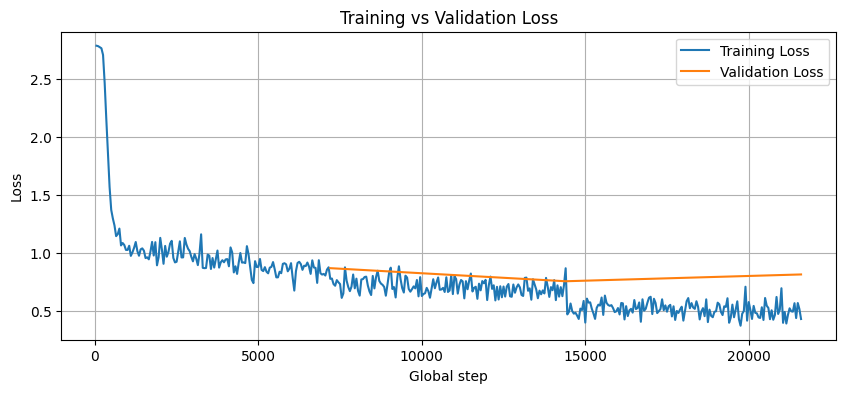

CPU times: user 1h 1min 28s, sys: 44 s, total: 1h 2min 12s
Wall time: 1h 23min 30s


In [15]:
%%time
# Use the train_model function from utility function
# This function handles model initialization, training args, trainer setup, and training.

# Get training arguments
args = get_training_args(cfg, num_labels, id2label, label2id)

# Explicitly set metric_for_best_model for EarlyStoppingCallback
if cfg.use_early_stopping:
    args.metric_for_best_model = "macro_f1"
    args.load_best_model_at_end = True

trainer, train_output = train_model(
    cfg.model_name,
    num_labels,
    id2label,
    label2id,
    tok_ds,
    collator,
    cfg,
    args
)

# Plot loss curves using the utility function
plot_loss_curves(trainer.state.log_history)

- The training process shows that the model's performance improved over the epochs, with both training and validation loss decreasing, and accuracy and macro F1 score increasing.
- The training stopped after 3 epochs, likely due to the Early Stopping Callback, which is configured to monitor the validation macro F1 and stop training if it doesn't improve for a certain number of epochs. This helps prevent overfitting and saves computational resources.

Classification Report (Train Data):
               precision    recall  f1-score   support

  EDAnonymous     0.9738    0.9773    0.9756      3574
    addiction     0.9549    0.9337    0.9441      3557
         adhd     0.9536    0.9471    0.9503      3666
   alcoholism     0.9473    0.9686    0.9578      3599
      anxiety     0.8246    0.8026    0.8134      3596
       autism     0.9628    0.9422    0.9524      3601
bipolarreddit     0.8955    0.8581    0.8764      3614
          bpd     0.8848    0.8409    0.8623      3608
   depression     0.7431    0.6910    0.7161      3599
healthanxiety     0.9458    0.9456    0.9457      3619
       lonely     0.8629    0.9022    0.8821      3579
       normal     0.9981    1.0000    0.9990      3605
         ptsd     0.9301    0.9247    0.9274      3600
schizophrenia     0.9175    0.9062    0.9119      3573
socialanxiety     0.8436    0.8931    0.8676      3611
 suicidewatch     0.7838    0.8816    0.8299      3599

     accuracy              

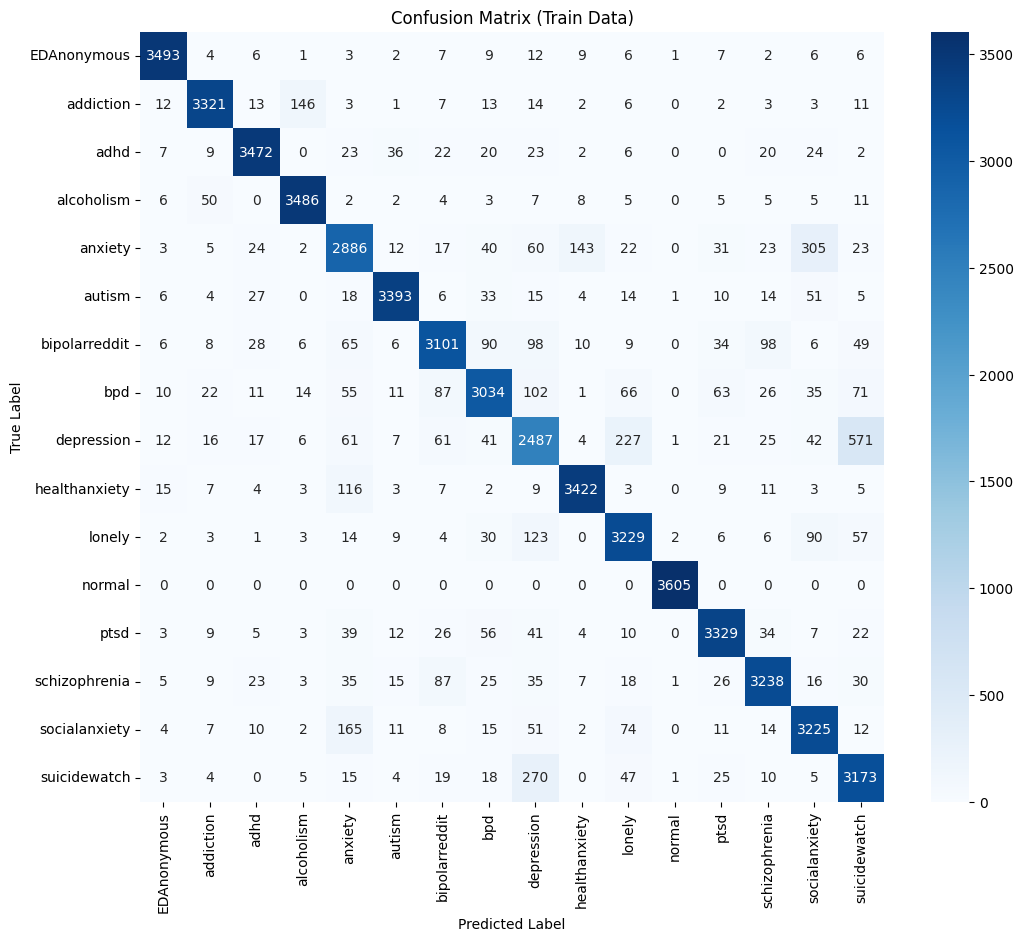

Accuracy on Train Set: 0.9009


In [ ]:
# Evaluate the model on the training set using the updated evaluate_model function
train_report, train_accuracy = evaluate_model(
    trainer,
    tok_ds,
    id2label,
    num_labels,
    split="train"
)


**Classification Report Summary on Training Set:**

- The classification report shows a high overall accuracy of **0.9009** on the training set.
- Many classes exhibit strong precision, recall, and F1-scores, indicating that the model has learned to classify these categories well during training.
- Notably, classes like `normal`, `EDAnonymous`, and `alcoholism` show very high performance metrics.

**Confusion Matrix Observations on Training Set:**

*   **Depression ↔ Suicidewatch:** There is a significant confusion between these two classes, with a notable number of `depression` posts being misclassified as `suicidewatch` (571 instances) and vice versa (270 instances). This is likely due to the semantic overlap and shared vocabulary related to despair and self-harm.
*   **Anxiety Family Collisions:** The model shows confusion among the anxiety-related categories (`anxiety`, `socialanxiety`, `healthanxiety`). This suggests that distinguishing between generic anxiety and more specific forms based on the text content remains challenging.
*   **BPD ↔ Bipolar:** There's some confusion between Borderline Personality Disorder (`bpd`) and `bipolarreddit`, likely stemming from shared language related to mood swings and relationship difficulties.
*   **Lonely → Depression:** A number of `lonely` posts are misclassified as `depression` (123 instances), which is understandable given the frequent co-occurrence and similar phrasing of symptoms.
*   **"Normal" Class Separation:** The `normal` class is almost perfectly separated, with very few instances being misclassified into other categories, and very few posts from other categories being misclassified as `normal`. This suggests the model is effective at identifying posts that do not fit into the specific mental health categories.

##### _Save trained RoBERTa model_

!!! We comment this part since there's restricted access to push to this repository, even if you can load from it

In [ ]:
# Log in to Hugging Face Hub
# notebook_login()

# Push the model, tokenizer, and label mappings to Hugging Face Hub
# push_to_hub(trainer, tok, cfg.hub_repo_id, id2label, label2id)

##### _Trained RoBERTa model inference on unseen data_

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Classification Report (Test Data):
               precision    recall  f1-score   support

  EDAnonymous     0.9135    0.9232    0.9183      1029
    addiction     0.8749    0.8340    0.8539      1048
         adhd     0.8395    0.8630    0.8511       927
   alcoholism     0.8695    0.9051    0.8869      1001
      anxiety     0.6400    0.6375    0.6387      1004
       autism     0.8870    0.8488    0.8675       999
bipolarreddit     0.8009    0.7520    0.7757       984
          bpd     0.7645    0.7306    0.7472       991
   depression     0.5220    0.4745    0.4971      1001
healthanxiety     0.8643    0.8652    0.8647       979
       lonely     0.7443    0.7341    0.7392      1023
       normal     0.9920    0.9990    0.9955       995
         ptsd     0.8453    0.8360    0.8406      1000
schizophrenia     0.8025    0.7971    0.7998      1030
socialanxiety     0.7100    0.7460    0.7275       988
 suicidewatch     0.6355    0.7542    0.6898      1001

     accuracy               

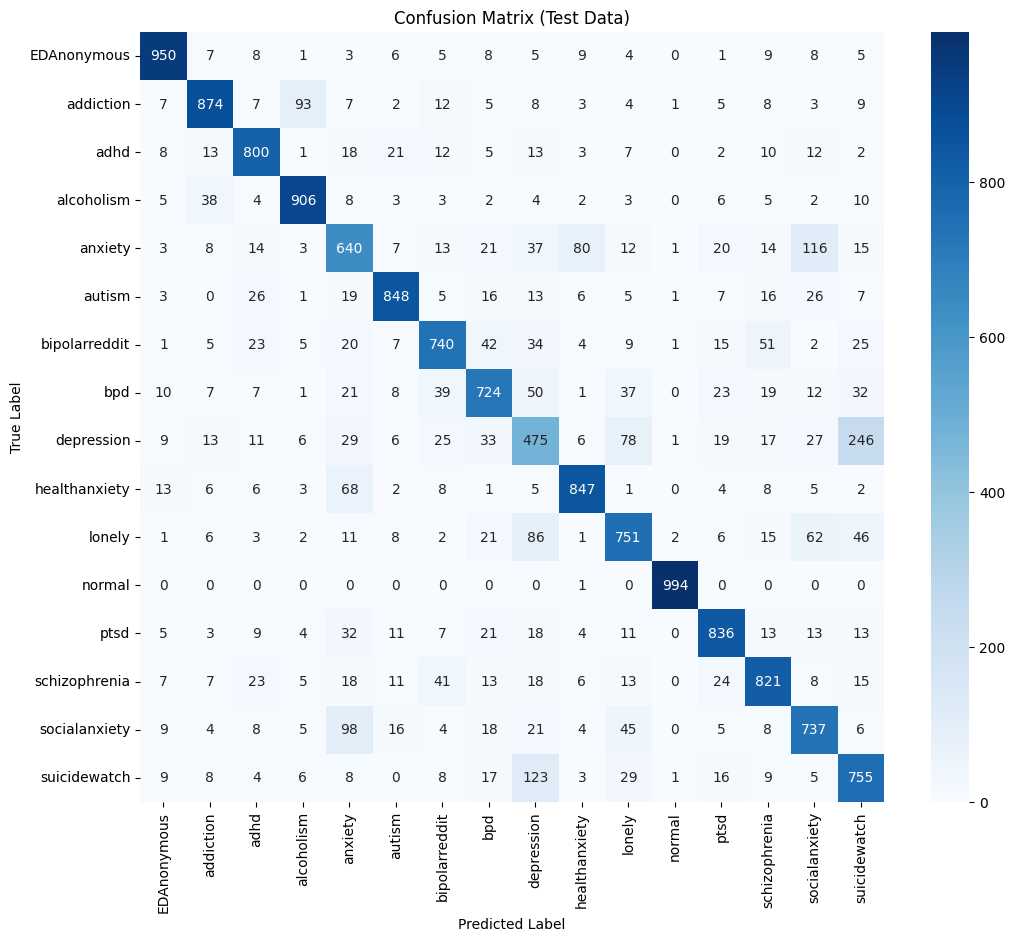

Accuracy on Test Set: 0.7936

Test Set Evaluation Results:
Accuracy: 0.7936


In [ ]:
# Load the model and tokenizer from Hugging Face Hub
loaded_model = AutoModelForSequenceClassification.from_pretrained(cfg.hub_repo_id) # Use cfg.hub_repo_id
loaded_tokenizer = AutoTokenizer.from_pretrained(cfg.hub_repo_id) # Use cfg.hub_repo_id

# Evaluate the model on the test set
test_report, test_accuracy = evaluate_model(
    trainer,
    tok_ds,
    id2label,
    num_labels,
    split="test"
)

print("\nTest Set Evaluation Results:")
print(f"Accuracy: {test_accuracy:.4f}")


##### _Comparison of RoBERTa-base Performance on Train and Test Sets_


| Metric        | Train Set | Test Set | Observation                                  |
| :------------ | :-------- | :------- | :------------------------------------------- |
| **Accuracy**  | 0.9009    | 0.7936   | Expected drop in accuracy on unseen data.    |
| **Macro F1**  | 0.9008    | 0.7934   | Similar drop in Macro F1, indicating consistent performance across classes. |
| **Normal Class F1** | 0.9990    | 0.9955   | The model maintains very high performance on the 'normal' class on unseen data. |
| **Depression F1** | 0.7161    | 0.4971   | A significant drop in Depression F1, highlighting challenges with this class on unseen data. |
| **Suicidewatch F1** | 0.8299    | 0.6898   | A notable drop in Suicidewatch F1, also indicating difficulty generalizing for this class. |
| **Anxiety F1** | 0.8134    | 0.6387   | A substantial decrease in Anxiety F1 on unseen data. |
| **Socialanxiety F1** | 0.8676    | 0.7275   | Performance on Socialanxiety also drops on unseen data. |
| **Healthanxiety F1** | 0.9457    | 0.8647   | Healthanxiety performance is more robust but still sees a drop. |


**Analysis:**

*   The performance metrics on the test set are lower than those on the training set, which is expected and indicates that the model has learned the training data well but faces some challenges generalizing to new, unseen data. This is a common sign of potential overfitting, although early stopping helps mitigate this.

*   The confusion patterns observed in the training set (e.g., between Depression and Suicidewatch, and within the Anxiety family) appear to persist and are often exacerbated on the test set, as evidenced by the larger performance drops for these specific classes.

*   The "normal" class continues to be well-classified on the test set, suggesting the model effectively learns to distinguish non-mental health related posts.

*   Looking at the confusion matrix on the test set, the model performs strongly on classes like `normal` (with high precision, recall, and F1-score), `EDAnonymous`, `healthanxiety`, `alcoholism`, and `autism`. The diagonal cells for these classes are notably dominant.

*   Conversely, certain classes and pairs remain challenging, showing higher rates of confusion:
    *   **Depression ↔ Suicidewatch:** This is the main confusion pair, with a significant number of `depression` posts misclassified as `suicidewatch` (246 instances) and vice versa (123 instances). `Depression` also shows some leakage to `lonely` (78 instances), which is semantically expected given the overlap in symptoms.
    *   **Anxiety Family:** Confusion persists within the anxiety-related classes, with notable misclassifications such as `anxiety` to `socialanxiety` (116 instances) and `anxiety` to `healthanxiety` (80 instances), and some reverse flow between these categories.
    *   **BPD ↔ Bipolarreddit:** There is continued confusion between `bpd` and `bipolarreddit`, with instances of `bpd` being misclassified as `bipolarreddit` (39) and `bipolarreddit` as `bpd` (42).

##### **4.2. DeBERTa-v3-base**

**What it is.** DeBERTa (Decoding-enhanced BERT with disentangled attention) improves upon BERT and RoBERTa by using a disentangled attention mechanism and a new masked language model pre-training objective. DeBERTa-v3 is a further improved version. For more information, you can refer to the [Hugging Face documentation](https://huggingface.co/docs/transformers/v4.57.1/en/model_doc/deberta#deberta).

**Key specs.**
- 12 layers · hidden size 768 · 12 attention heads (~125M params)
- Uses a SentencePiece tokenizer; max seq length 512
- Pretrained on a large text corpus

**Why use it.**
- Achieved state-of-the-art results on various NLP benchmarks, including SuperGLUE.
- The disentangled attention mechanism can capture richer interactions between tokens.

**My fine-tuning approach.**
- Similar fine-tuning parameters as RoBERTa (LR, batch size, max_length).
- We will use Early Stopping based on validation macro-F1.

In [ ]:
# Configuration for DeBERTa-v3-base model
cfg_deberta = Config(
    model_name="microsoft/deberta-v3-base",
    max_length=384,
    batch_size=16,
    epochs=10,
    lr=2e-5,
    gradient_accumulation=2,
    eval_strategy="epoch",
    hub_repo_id="paragonadey/mh-text-classifier-deberta-v3-base_v2"
)

set_seed(cfg_deberta.seed)

# Use tokenize_datasets from utility function for DeBERTa
# raw_datasets, label2id, id2label, num_labels were created in the RoBERTa section and can be reused
tok_ds_deberta, tok_deberta, collator_deberta = tokenize_datasets(raw_datasets, cfg_deberta.model_name, cfg_deberta.max_length)

Seed set to 42


C:\Users\acoue\.conda\envs\myenv\Lib\site-packages\transformers\convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Map: 100%|██████████| 16000/16000 [00:11<00:00, 1334.21 examples/s]

Tokenized datasets:
DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 57600
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6400
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 16000
    })
})


In [ ]:
# Run this cell to get this DeBERTa model parameters
deberta_model = AutoModelForSequenceClassification.from_pretrained(cfg_deberta.model_name, num_labels=num_labels)
deberta_params_df, deberta_layer_summary_df, deberta_total_params, deberta_trainable_params = summarize_model_parameters(deberta_model, "DeBERTa-v3-base")

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters (DeBERTa-v3-base Model): 184434448
Trainable parameters (DeBERTa-v3-base Model): 184434448

DeBERTa-v3-base Model Parameters (by layer):


,Layer Name,Shape,Number of Parameters,Trainable
0,deberta.embeddings.word_embeddings.weight,"(128100, 768)",98380800,True
1,deberta.embeddings.LayerNorm.weight,"(768,)",768,True
2,deberta.embeddings.LayerNorm.bias,"(768,)",768,True
3,deberta.encoder.layer.0.attention.self.query_p...,"(768, 768)",589824,True
4,deberta.encoder.layer.0.attention.self.query_p...,"(768,)",768,True
...,...,...,...,...
197,deberta.encoder.LayerNorm.bias,"(768,)",768,True
198,pooler.dense.weight,"(768, 768)",589824,True
199,pooler.dense.bias,"(768,)",768,True
200,classifier.weight,"(16, 768)",12288,True



Parameter Count by Layer Type (DeBERTa-v3-base Model):


,Layer Type,Number of Parameters
0,classifier,12304
1,deberta,183831552
2,pooler,590592


As shown in the output above:

*   The DeBERTa-v3-base model has a total of **184,434,448 parameters**, all of which are trainable.
*   The parameters are primarily distributed among the `deberta` layers (the main transformer encoder), the `pooler` layer, and the `classifier` layers (the newly added classification head).
*   The majority of the parameters reside in the `deberta` layers (183,831,552), while the `pooler` layer contains 590,592 parameters and the `classifier` layers, which are newly initialized for this downstream task, contain a smaller number of parameters (12,304).

##### _DeBERTa model training - evaluation_

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
/content/nlp_utils.py:174: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` 

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Prec,Macro Rec
1,0.863600,0.909242,0.745781,0.747754,0.762223,0.745883
2,0.830300,0.759221,0.782500,0.782116,0.787091,0.782590
3,0.510100,0.793416,0.792344,0.792877,0.794619,0.792363


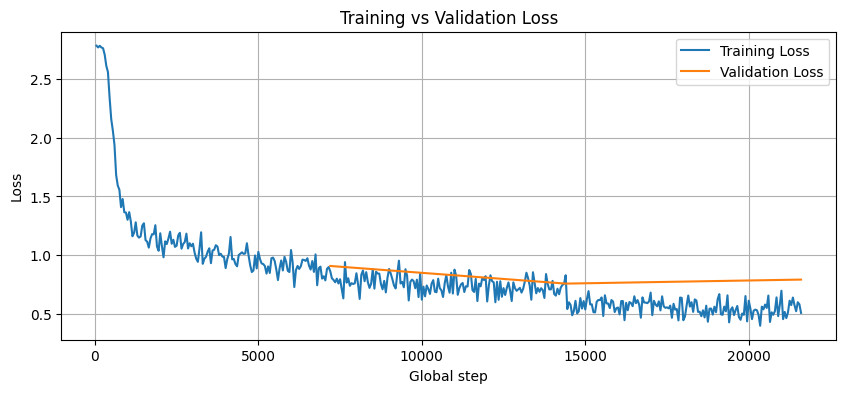

CPU times: user 36min 20s, sys: 57 s, total: 37min 17s
Wall time: 37min 25s


In [ ]:
%%time

# Get training arguments for DeBERTa
args_deberta = get_training_args(cfg_deberta, num_labels, id2label, label2id)

# Explicitly set metric_for_best_model for EarlyStoppingCallback (if used)
if cfg_deberta.use_early_stopping:
    args_deberta.metric_for_best_model = "macro_f1"
    args_deberta.load_best_model_at_end = True

# Use the train_model function from nlp_utils.py for DeBERTa training
trainer_deberta, train_output_deberta = train_model(
    cfg_deberta.model_name,
    num_labels,
    id2label,
    label2id,
    tok_ds_deberta, # Use DeBERTa tokenized dataset
    collator_deberta, # Use DeBERTa data collator
    cfg_deberta, # Use DeBERTa config
    args_deberta # Use DeBERTa training arguments
)

# Plot loss curves using the utility function for DeBERTa
plot_loss_curves(trainer_deberta.state.log_history)

**Training Report (DeBERTa-v3-base):**

**Learning Curve:** The training loss decreased quickly initially (from ~2.7, though not shown in this summary table, to ~0.5 by epoch 3) and then continued a slower decline, indicating healthy optimization.

**Validation Trend:** The validation metrics, particularly the loss, showed improvement in the early epochs (from ~0.90 down to a minimum near ~0.78 mid-training) but then crept up slightly towards the end of training. Macro F1 and accuracy followed a similar pattern of initial improvement followed by a slight plateau or dip.


This trend suggests mild overfitting after the midpoint of training. The model continued to improve its fit on the training data (decreasing training loss), while its ability to generalize to the unseen validation data plateaued and began to slightly worsen (validation loss creeping up). Despite this, the overall training process was stable and the model converged.

Classification Report (Train Data):
               precision    recall  f1-score   support

  EDAnonymous     0.9762    0.9751    0.9756      3574
    addiction     0.9531    0.9190    0.9357      3557
         adhd     0.9445    0.9422    0.9433      3666
   alcoholism     0.9339    0.9619    0.9477      3599
      anxiety     0.7793    0.7828    0.7811      3596
       autism     0.9596    0.9236    0.9413      3601
bipolarreddit     0.8709    0.8343    0.8522      3614
          bpd     0.8585    0.8140    0.8357      3608
   depression     0.7019    0.6655    0.6832      3599
healthanxiety     0.9403    0.9276    0.9339      3619
       lonely     0.8401    0.8790    0.8591      3579
       normal     0.9978    0.9994    0.9986      3605
         ptsd     0.9243    0.9083    0.9162      3600
schizophrenia     0.8808    0.8959    0.8883      3573
socialanxiety     0.8315    0.8610    0.8460      3611
 suicidewatch     0.7722    0.8639    0.8155      3599

     accuracy              

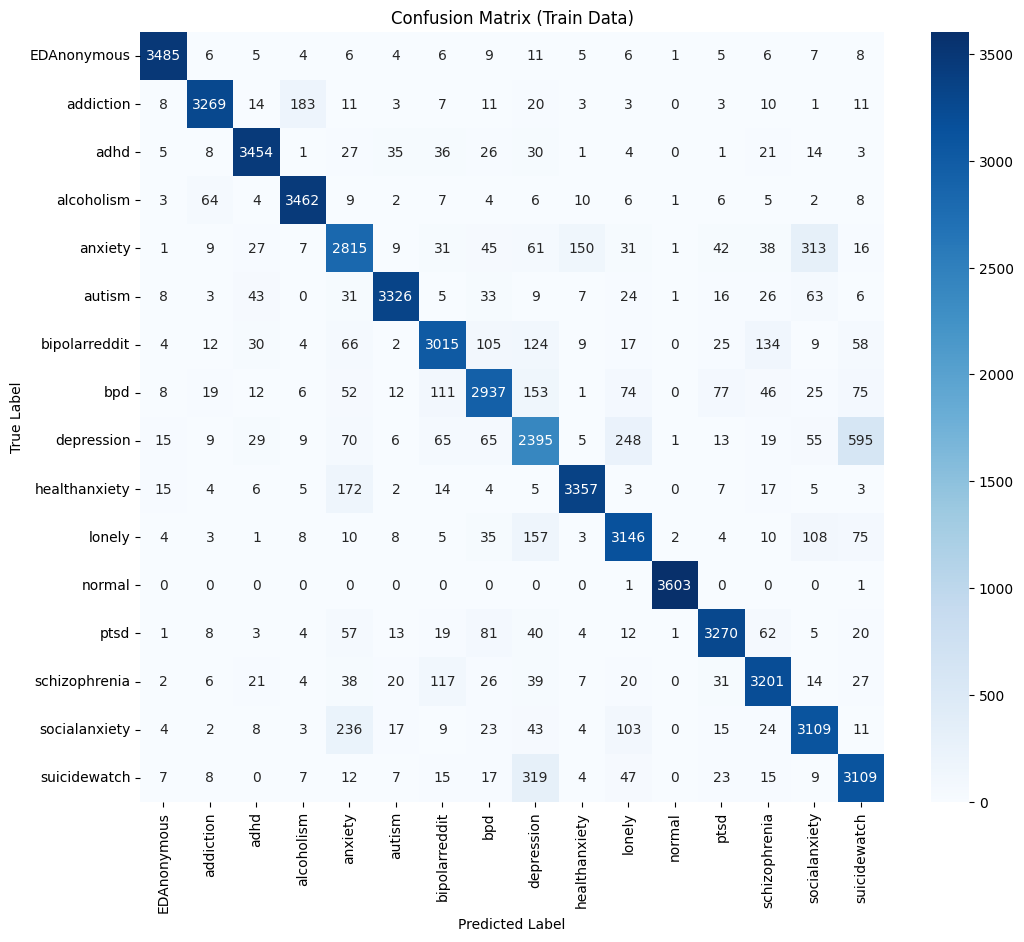

Accuracy on Train Set: 0.8846


In [ ]:
# Evaluate the DeBERTa model on the training set.
train_report_deberta, train_accuracy_deberta = evaluate_model(
    trainer_deberta,
    tok_ds_deberta,
    id2label,
    num_labels,
    split="train"
)

**Classification Report Summary on Training Set:**

*   **Very strong classes:** Classes with notably high F1-scores include `normal` (≈0.999), `EDAnonymous`, `alcoholism`, `autism`, `healthanxiety`, and `ptsd`.
*   **Weaker classes:** Classes with lower F1-scores, indicating more difficulty in classification, include `depression` (≈0.68), `anxiety` (≈0.78), `bpd`/`bipolarreddit` (mid-0.8s), `suicidewatch` (≈0.82), and `socialanxiety` (≈0.85).

**Confusion Matrix Observations on Training Set:**

*   **Depression ↔ Suicidewatch:** This remains the most significant source of confusion. A large number of `depression` posts are misclassified as `suicidewatch` (595 instances), and vice versa (319 instances). This is expected due to the semantic overlap between these topics.
*   **Anxiety Family Mixing:** Confusion persists within the anxiety-related classes. `anxiety` is frequently misclassified as `socialanxiety` (313 instances) and `healthanxiety` (150 instances), with some reverse misclassifications as well.
*   **BPD ↔ Bipolarreddit:** There is notable confusion between Borderline Personality Disorder (`bpd`) and `bipolarreddit`, with instances of `bpd` being misclassified as `bipolarreddit` (111) and `bipolarreddit` as `bpd` (124). This likely stems from shared language related to mood and instability.
*   **Lonely → Depression:** A considerable number of `lonely` posts are misclassified as `depression` (157 instances), which is understandable given the semantic proximity and frequent co-occurrence of these states.

##### _Save trained DeBERTa model_

!!! We comment this part since there's restricted access to push to this repository, even if you can load from it

In [ ]:
# Push the DeBERTa model, tokenizer, and label mappings to Hugging Face Hub
# push_to_hub(trainer_deberta, tok_deberta, cfg_deberta.hub_repo_id, id2label, label2id)

##### _Trained DeBERTa model inference on unseen data_

Classification Report (Test Data):
               precision    recall  f1-score   support

  EDAnonymous     0.9410    0.9300    0.9355      1029
    addiction     0.8869    0.8378    0.8616      1048
         adhd     0.8365    0.8662    0.8511       927
   alcoholism     0.8610    0.9161    0.8877      1001
      anxiety     0.6350    0.6514    0.6431      1004
       autism     0.9080    0.8498    0.8780       999
bipolarreddit     0.7886    0.7581    0.7731       984
          bpd     0.7694    0.7205    0.7441       991
   depression     0.5252    0.4895    0.5067      1001
healthanxiety     0.8631    0.8693    0.8662       979
       lonely     0.7398    0.7478    0.7438      1023
       normal     0.9950    0.9960    0.9955       995
         ptsd     0.8613    0.8320    0.8464      1000
schizophrenia     0.7889    0.8126    0.8006      1030
socialanxiety     0.7148    0.7358    0.7252       988
 suicidewatch     0.6567    0.7453    0.6982      1001

     accuracy               

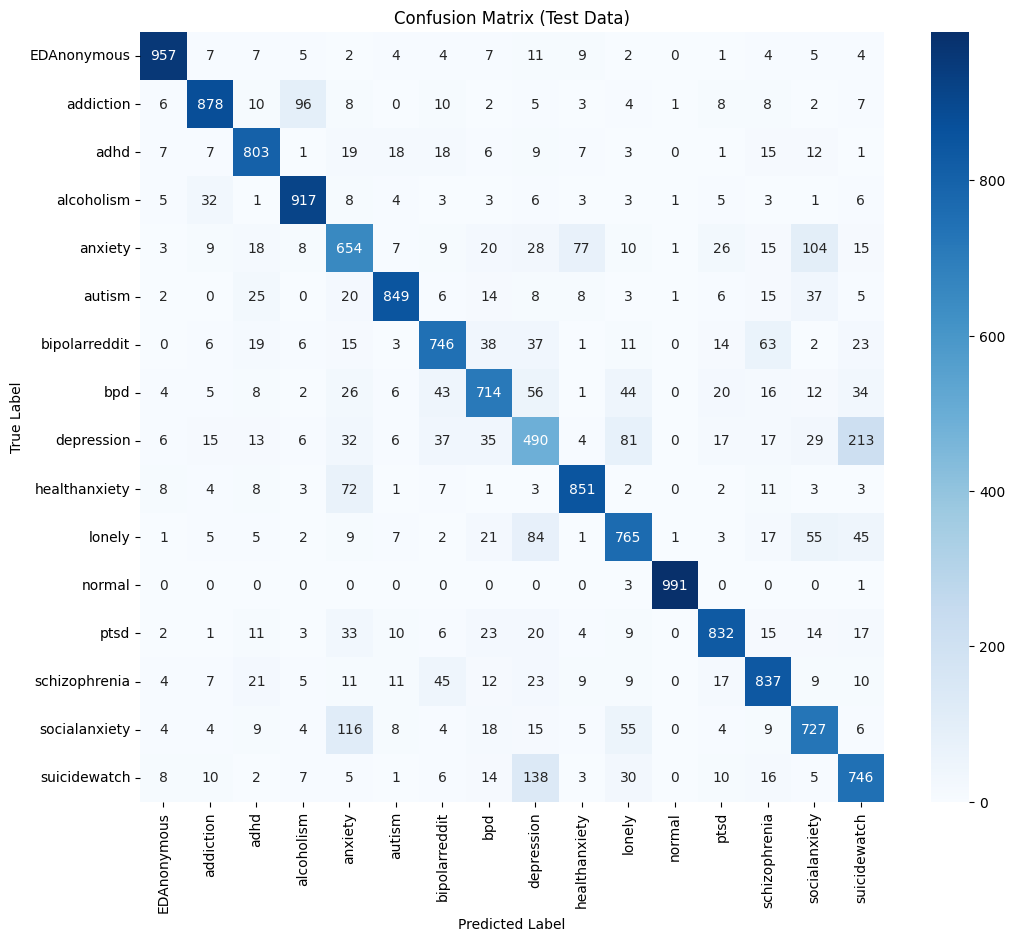

Accuracy on Test Set: 0.7973

Test Set Evaluation Results (DeBERTa Model):
Accuracy: 0.7973


In [ ]:
# Evaluate the DeBERTa model on the test set using the updated evaluate_model function
test_report_deberta, test_accuracy_deberta = evaluate_model(
    trainer_deberta, # Use the DeBERTa trainer
    tok_ds_deberta, # Use the DeBERTa tokenized dataset
    id2label, # Use the id2label mapping
    num_labels, # Use the number of labels
    split="test" # Specify the test split
)

print("\nTest Set Evaluation Results (DeBERTa Model):")
print(f"Accuracy: {test_accuracy_deberta:.4f}")

##### _Comparison of DeBERTa-v3-base Performance on Train and Test Sets_

| Metric        | Train Set | Test Set | Observation                                  |
| :------------ | :-------- | :------- | :------------------------------------------- |
| **Accuracy**  | 0.8846    | 0.7973   | Expected drop in accuracy on unseen data, but still solid generalization. |
| **Macro F1**  | 0.8846    | 0.7973   | Similar drop in Macro F1, indicating consistent performance across classes on test set. |
| **Normal Class F1** | 0.9986    | 0.9955   | Maintains very high performance on the 'normal' class on unseen data. |
| **Depression F1** | 0.6832    | 0.5067   | Significant drop in Depression F1, highlighting challenges with this class on unseen data. |
| **Suicidewatch F1** | 0.8155    | 0.6982   | Notable drop in Suicidewatch F1, also indicating difficulty generalizing for this class. |
| **Anxiety F1** | 0.7811    | 0.6431   | Substantial decrease in Anxiety F1 on the test set. |
| **Socialanxiety F1** | 0.8460    | 0.7252   | Performance on Socialanxiety also drops on the test set. |
| **Healthanxiety F1** | 0.9339    | 0.8662   | Healthanxiety performance is more robust but still sees a drop. |

**Analysis:**

*   Looking at the confusion matrix on the test set, the model performs strongly on classes with F1 scores generally above 0.86, including `normal` (0.996), `EDAnonymous` (0.936), `alcoholism` (0.888), `healthanxiety` (0.866), `autism` (0.878), `ptsd` (0.846), `addiction` (0.862), and `adhd` (0.851).

*   Classes with moderate performance (F1 between 0.72 and 0.81) include `bipolarreddit` (0.773), `bpd` (0.744), `lonely` (0.744), `schizophrenia` (0.801), and `socialanxiety` (0.725).

*   Certain classes remain particularly challenging for the model to classify accurately on unseen data, showing lower F1 scores: `anxiety` (0.643), `suicidewatch` (0.698), and `depression` (0.507).

*   Analysis of the confusion matrix reveals similar confusion patterns as observed on the training set, often exacerbated on the test data:
    *   **Depression ↔ Suicidewatch:** This is a significant two-way confusion, with approximately 213 `depression` posts misclassified as `suicidewatch` and around 138 `suicidewatch` posts misclassified as `depression`. Additionally, about 81 `depression` posts are misclassified as `lonely`, which is semantically understandable.
    *   **Anxiety Family:** Confusion persists among the anxiety-related classes, with notable misclassifications such as `anxiety` to `socialanxiety` (around 104 instances) and `anxiety` to `healthanxiety` (around 77 instances), along with some reverse flow.
    *   **BPD ↔ Bipolarreddit:** There are swaps in both directions between `bpd` and `bipolarreddit`, with approximately 43 `bpd` posts misclassified as `bipolarreddit` and about 38 `bipolarreddit` posts misclassified as `bpd`.

##### **4.3.  ModernBERT-large**

**What it is.** ModernBERT is another variant of BERT, aiming for improved performance. The "large" version indicates a larger model size compared to base models. For more information, you can refer to the [Hugging Face documentation](https://huggingface.co/docs/transformers/v4.57.1/en/model_doc/modernbert#modernbert).

**Key specs.**
- Larger number of parameters compared to base models.
- Specific architecture details and pre-training may vary.

**Why use it.**
- Larger models often have higher capacity to learn complex patterns.
- I want to compare its performance against established models like RoBERTa and DeBERTa on this specific task.

**Fine-tuning approach.**
- Similar fine-tuning parameters as the other models.
- We will use Early Stopping based on validation macro-F1.
- We plan to perform hyperparameter tuning specifically for this model to potentially optimize its performance further.# ModerBERT

In [ ]:
# Configuration for ModernBERT-large model
cfg_moderbert = Config(
    model_name="answerdotai/ModernBERT-large",
    max_length=384, # Keep max_length consistent for comparison
    batch_size=16,  # Keep batch_size consistent
    epochs=5,       # Start with 5 epochs, early stopping will control actual epochs
    lr=2e-5,
    gradient_accumulation=2, # Keep consistent
    eval_strategy="epoch",
    hub_repo_id="paragonadey/mh-text-classifier-moderbert-large_v2" # Set repository ID for ModerBERT model
)

set_seed(cfg_moderbert.seed) # Set seed for reproducibility with this config

# Use tokenize_datasets from nlp_utils for ModerBERT
tok_ds_moderbert, tok_moderbert, collator_moderbert = tokenize_datasets(raw_datasets, cfg_moderbert.model_name, cfg_moderbert.max_length)

Seed set to 42


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/57600 [00:00<?, ? examples/s]

Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Tokenized datasets:
DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 57600
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 6400
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
})


In [ ]:
# Run this cell to get this ModernBERT model parameters
moderbert_model = AutoModelForSequenceClassification.from_pretrained(cfg_moderbert.model_name, num_labels=num_labels)
moderbert_params_df, moderbert_layer_summary_df, moderbert_total_params, moderbert_trainable_params = summarize_model_parameters(moderbert_model, "ModernBERT-large")

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters (ModernBERT-large Model): 395847696
Trainable parameters (ModernBERT-large Model): 395847696

ModernBERT-large Model Parameters (by layer):


,Layer Name,Shape,Number of Parameters,Trainable
0,model.embeddings.tok_embeddings.weight,"(50368, 1024)",51576832,True
1,model.embeddings.norm.weight,"(1024,)",1024,True
2,model.layers.0.attn.Wqkv.weight,"(3072, 1024)",3145728,True
3,model.layers.0.attn.Wo.weight,"(1024, 1024)",1048576,True
4,model.layers.0.mlp_norm.weight,"(1024,)",1024,True
...,...,...,...,...
169,model.final_norm.weight,"(1024,)",1024,True
170,head.dense.weight,"(1024, 1024)",1048576,True
171,head.norm.weight,"(1024,)",1024,True
172,classifier.weight,"(16, 1024)",16384,True



Parameter Count by Layer Type (ModernBERT-large Model):


,Layer Type,Number of Parameters
0,classifier,16400
1,head,1049600
2,model,394781696


As shown in the output above:

*   The ModernBERT-large model has a total of **395,847,696 parameters**, all of which are trainable.
*   The parameters are primarily distributed among the `model` layers (the main transformer encoder), the `head` layer, and the `classifier` layers (the newly added classification head).
*   The vast majority of the parameters reside in the `model` layers (394,781,696), while the `head` layer contains 1,049,600 parameters and the `classifier` layers, which are newly initialized for this downstream task, contain a smaller number of parameters (16,400).

##### _ModerBERT model training - evaluation_

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/content/nlp_utils.py:174: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': None, 'bos_token_id': None}.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Prec,Macro Rec
1,0.659800,0.732131,0.775937,0.774674,0.793977,0.776178
2,0.567100,0.671080,0.798594,0.799027,0.804637,0.798685
3,0.139300,1.166926,0.796875,0.797586,0.798835,0.796956


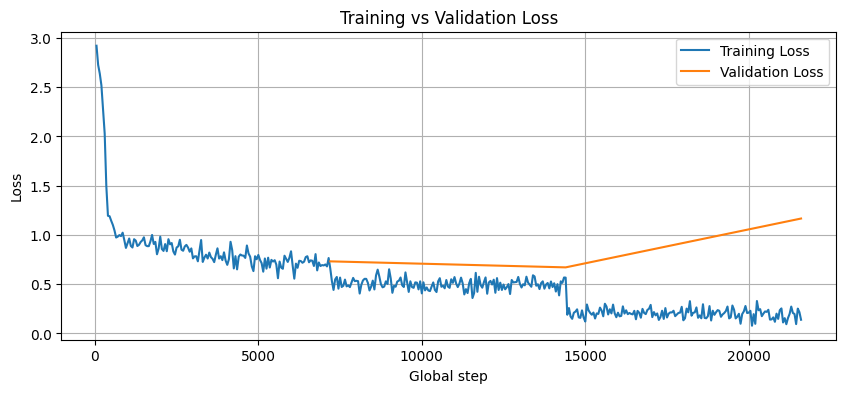

CPU times: user 57min 22s, sys: 1min 30s, total: 58min 53s
Wall time: 49min 57s


In [ ]:
%%time

# Get training arguments for ModerBERT
args_moderbert = get_training_args(cfg_moderbert, num_labels, id2label, label2id)

# Explicitly set metric_for_best_model for EarlyStoppingCallback (if used)
if cfg_moderbert.use_early_stopping:
    args_moderbert.metric_for_best_model = "macro_f1"
    args_moderbert.load_best_model_at_end = True

# Use the train_model function from utility function
trainer_moderbert, train_output_moderbert = train_model(
    cfg_moderbert.model_name,
    num_labels,
    id2label,
    label2id,
    tok_ds_moderbert,
    collator_moderbert,
    cfg_moderbert,
    args_moderbert
)

# Plot loss curves using the utility function for ModerBERT
plot_loss_curves(trainer_moderbert.state.log_history)

**Training Report (ModernBERT-large):**

*   **Fast Fit Phase (0 → ~1k steps):** Training loss plunges quickly from approximately 2.9 to 1.0. This indicates that the model rapidly adapts to the task, likely driven by the initial warmup and large gradient updates.
*   **Stable Improvement (~1k → ~7k):** Training loss continues a steady decline towards approximately 0.7. Validation points begin appearing around 7k steps, with validation loss around 0.75–0.8.
*   **Sweet Spot (~7k → ~14.5k):** Training loss continues to decrease slightly (around 0.5–0.6), while validation performance remains relatively flat or shows slight improvement. This plateau phase typically represents the point where the best model checkpoint is likely to be found.
*   **Overfitting Onset (~14.5k → end):** A clear divergence occurs as training loss drops significantly lower (to around 0.2–0.3), but validation loss steadily climbs (from approximately 0.7 to over 1.1). This indicates classic overfitting, where the model is memorizing the training data but losing its ability to generalize to unseen data.

Classification Report (Train Data):
               precision    recall  f1-score   support

  EDAnonymous     0.9980    0.9975    0.9978      3574
    addiction     0.9904    0.9837    0.9870      3557
         adhd     0.9962    0.9962    0.9962      3666
   alcoholism     0.9854    0.9933    0.9893      3599
      anxiety     0.9781    0.9691    0.9736      3596
       autism     0.9964    0.9947    0.9956      3601
bipolarreddit     0.9825    0.9762    0.9793      3614
          bpd     0.9865    0.9748    0.9806      3608
   depression     0.9695    0.9544    0.9619      3599
healthanxiety     0.9922    0.9901    0.9911      3619
       lonely     0.9720    0.9902    0.9810      3579
       normal     0.9997    1.0000    0.9999      3605
         ptsd     0.9919    0.9908    0.9914      3600
schizophrenia     0.9839    0.9910    0.9875      3573
socialanxiety     0.9767    0.9850    0.9808      3611
 suicidewatch     0.9712    0.9833    0.9772      3599

     accuracy              

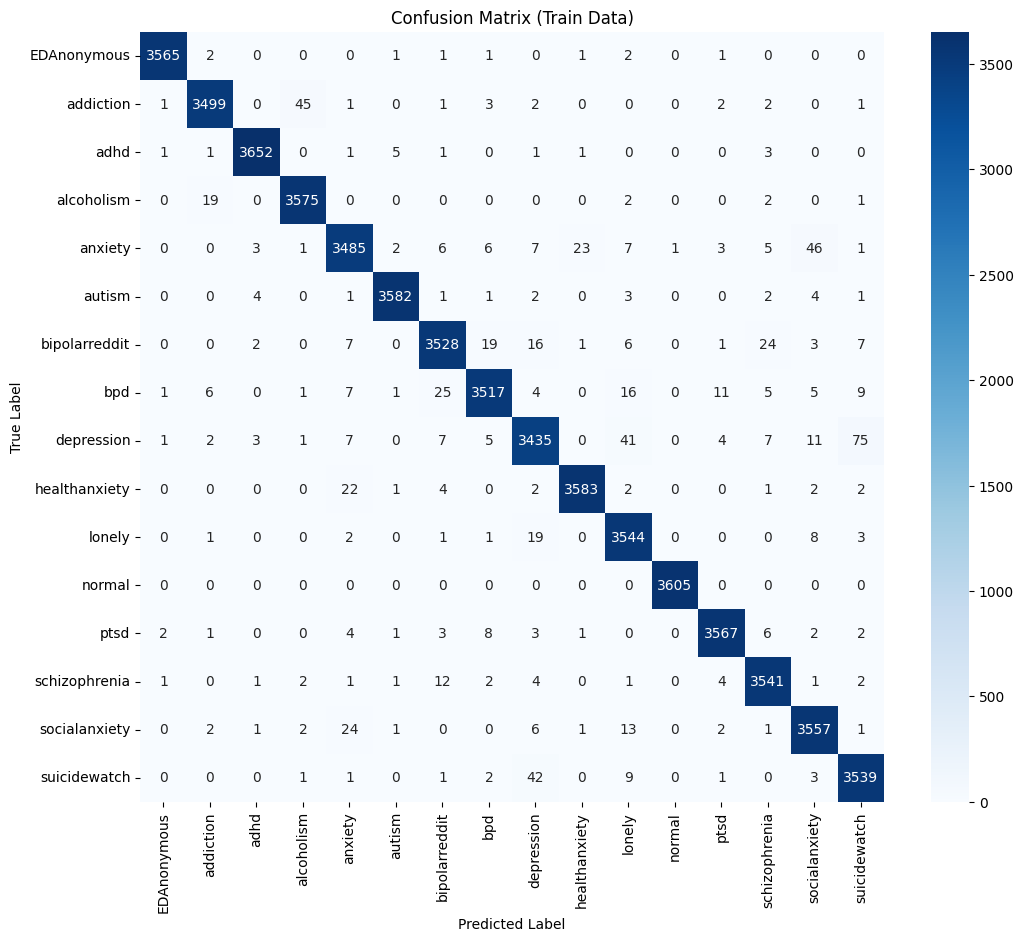

Accuracy on Train Set: 0.9857


In [ ]:
# Evaluate the ModerBERT model on the training set
train_report_moderbert, train_accuracy_moderbert = evaluate_model(
    trainer_moderbert,
    tok_ds_moderbert,
    id2label,
    num_labels,
    split="train"
)


**Classification Report Summary on Training data**

The classification report shows a very high overall accuracy of **0.9857** on the training set. The macro average F1 score is also **0.9856**, indicating excellent and balanced performance across classes on the training data.

*   **Very strong classes:** The evaluation shows very high training accuracy, with most classes being learned almost perfectly. Classes like `normal`, `EDAnonymous`, `alcoholism`, `autism`, `healthanxiety`, `ptsd`, `schizophrenia`, and `adhd` exhibit huge diagonal counts in the confusion matrix with minimal misclassification.

**Confusion Matrix Observations on the Training data:**

*   **Depression ↔ Suicidewatch:** There is a notable tail of misclassifications between `depression` and `suicidewatch`. Additionally, some `depression` posts are misclassified as `lonely`.
*   **Anxiety Family Mixing:** Confusion persists within the anxiety family, with instances of `anxiety` being misclassified as `socialanxiety` and `healthanxiety`.
*   **BPD ↔ Bipolarreddit:** There is a modest two-way swap of misclassifications between `bpd` and `bipolarreddit`.

##### _Save trained ModerBERT model_

!!! We comment this part since there's restricted access to push to this repository, even if you can load from it

In [ ]:
# Push the ModerBERT model, tokenizer, and label mappings to Hugging Face Hub
# push_to_hub(trainer_moderbert, tok_moderbert, cfg_moderbert.hub_repo_id, id2label, label2id)

##### _Trained ModerBERT model inference on unseen data_

Classification Report (Test Data):
               precision    recall  f1-score   support

  EDAnonymous     0.9227    0.9397    0.9312      1029
    addiction     0.8939    0.8445    0.8685      1048
         adhd     0.8370    0.8975    0.8662       927
   alcoholism     0.8694    0.9111    0.8898      1001
      anxiety     0.6427    0.6594    0.6509      1004
       autism     0.9094    0.8739    0.8913       999
bipolarreddit     0.7963    0.7825    0.7893       984
          bpd     0.7996    0.7366    0.7668       991
   depression     0.5326    0.5465    0.5394      1001
healthanxiety     0.8800    0.8764    0.8782       979
       lonely     0.7553    0.7664    0.7608      1023
       normal     0.9930    0.9990    0.9960       995
         ptsd     0.8697    0.8480    0.8587      1000
schizophrenia     0.8322    0.8379    0.8350      1030
socialanxiety     0.7394    0.7379    0.7386       988
 suicidewatch     0.6950    0.7013    0.6982      1001

     accuracy               

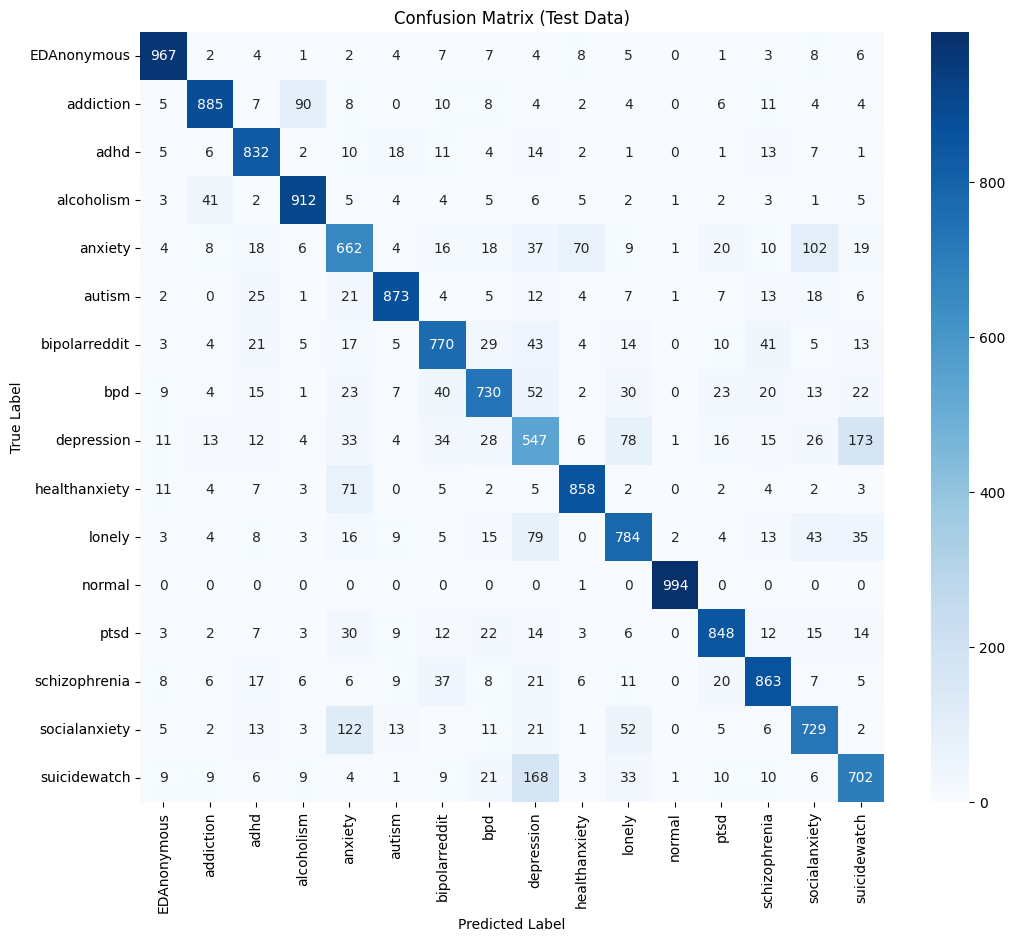

Accuracy on Test Set: 0.8097

Test Set Evaluation Results (ModerBERT Model):
Accuracy: 0.8097


In [ ]:
# Evaluate the ModerBERT model on the test set
test_report_moderbert, test_accuracy_moderbert = evaluate_model(
    trainer_moderbert,
    tok_ds_moderbert,
    id2label,
    num_labels,
    split="test"
)

print("\nTest Set Evaluation Results (ModerBERT Model):")
print(f"Accuracy: {test_accuracy_moderbert:.4f}")

##### _Comparison of ModernBERT-large Performance on Train and Test Sets_


| Metric        | Train Set | Test Set | Observation                                  |
| :------------ | :-------- | :------- | :------------------------------------------- |
| **Accuracy**  | 0.9857    | 0.8097   | Expected drop in accuracy on unseen data, but significantly higher than base models. |
| **Macro F1**  | 0.9856    | 0.8099   | Significant drop from train, indicating overfitting, but still strong generalization. |
| **Normal Class F1** | 0.9999    | 0.9960   | Maintains exceptionally high performance on the 'normal' class on unseen data. |
| **Depression F1** | 0.9619    | 0.5394   | Very significant drop in Depression F1, indicating this remains a very challenging class for generalization. |
| **Suicidewatch F1** | 0.9772    | 0.6982   | Significant drop in Suicidewatch F1, also indicating difficulty generalizing for this class. |
| **Anxiety F1** | 0.9736    | 0.6509   | Substantial decrease in Anxiety F1 on the test set. |
| **Socialanxiety F1** | 0.9808    | 0.7386   | Performance on Socialanxiety also drops on the test set. |
| **Healthanxiety F1** | 0.9911    | 0.8782   | Healthanxiety performance is more robust but still sees a notable drop. |

**Analysis:**

*   The confusion matrix on the test set is strongly diagonal, indicating good generalization for many classes. Classes with very high separation, showing large diagonal counts and minimal spillover to other classes, include `normal` (almost perfect), `EDAnonymous`, `healthanxiety`, `alcoholism`, `autism`, `PTSD`, `ADHD`, `addiction`, and `schizophrenia`.

*   However, the model still struggles with certain semantically close pairs, where confusion is more pronounced:
    *   **Depression ↔ Suicidewatch:** This remains the heaviest two-way confusion on the test set. There is a notable block of `depression` posts misclassified as `suicidewatch`, and a significant number of `suicidewatch` posts misclassified as `depression`. Some `depression` posts are also misclassified as `lonely`.
    *   **Anxiety Family:** Mixing within the anxiety family persists, with visible misclassifications such as `anxiety` to `socialanxiety` and `anxiety` to `healthanxiety`.
    *   **BPD ↔ Bipolarreddit:** There are visible swaps in both directions between `bpd` and `bipolarreddit`.

### **6. Results, Interpretation & Future Works**

- We evaluated three Transformer models (RoBERTa-base, DeBERTa-v3-base, and ModernBERT-large) for mental health text classification. As a quick reminder :

| Model              | Train Accuracy | Test Accuracy | Train Macro F1 | Test Macro F1 | Total Parameters |
| :----------------- | :------------- | :------------ | :------------- | :------------ | :--------------- |
| **RoBERTa-base**   | 0.9009         | 0.7936        | 0.9008         | 0.7934        | 124.7M           |
| **DeBERTa-v3-base**| 0.8846         | 0.7973        | 0.8846         | 0.7973        | 184.4M           |
| **ModernBERT-large**| 0.9857        | 0.8097        | 0.9856         | 0.8099        | 395.8M           |

- All models performed reasonably well on the test set (Accuracy ~0.79-0.81).

- **ModernBERT-large** achieved the highest test performance but showed more overfitting than base models.

- **DeBERTa-v3-base** slightly outperformed **RoBERTa-base**.

- Persistent confusion exists between semantically similar classes, particularly **Depression ↔ Suicidewatch** and within the **Anxiety family**. The **"normal"** class was consistently well-classified.

As future works :

*   **Hyperparameter tuning** (computationally expensive but potentially beneficial).
*   **Ensemble methods** for improved robustness.
*   Exploring **alternative model architectures**.
*   **Data augmentation** for weaker classes.
*   **Specialized tokenization/embeddings** for mental health language.
*   **Incorporating external knowledge**.